Fitting 5 folds for each of 72 candidates, totalling 360 fits
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

     No Rain       1.00      1.00      1.00       437
        Rain       1.00      1.00      1.00        63

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



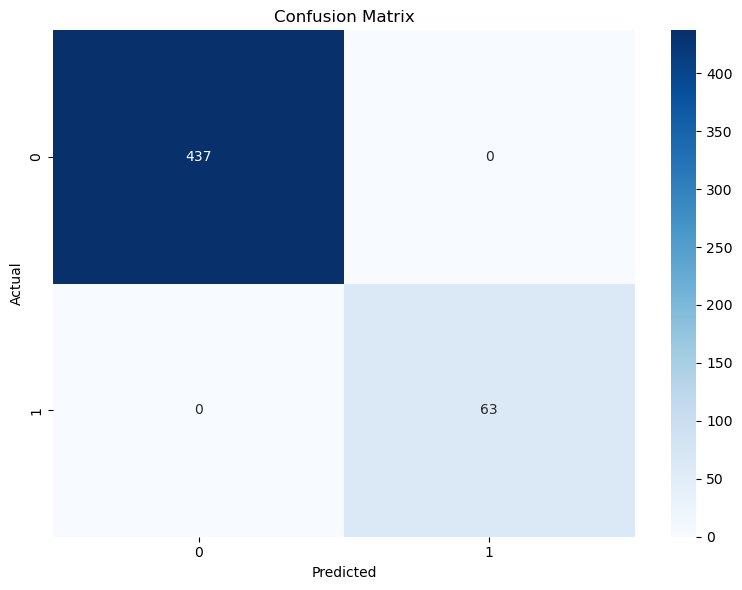

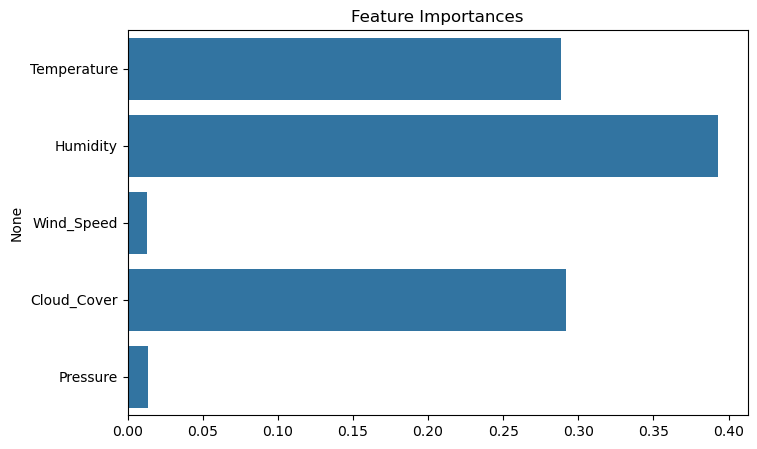

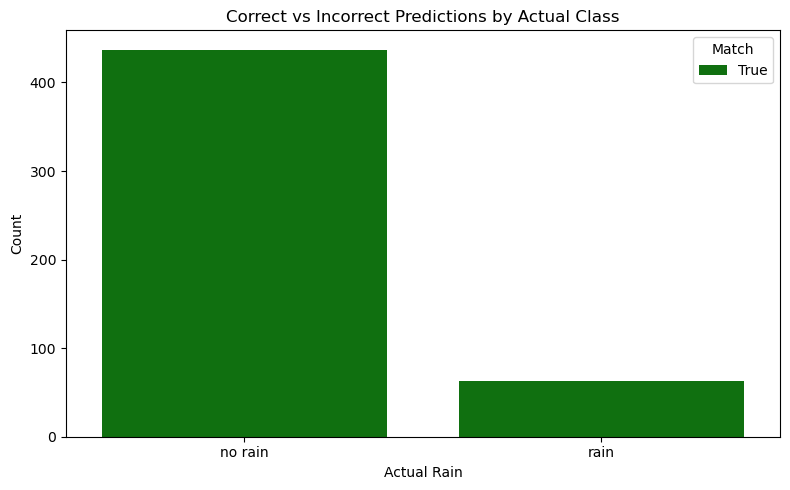

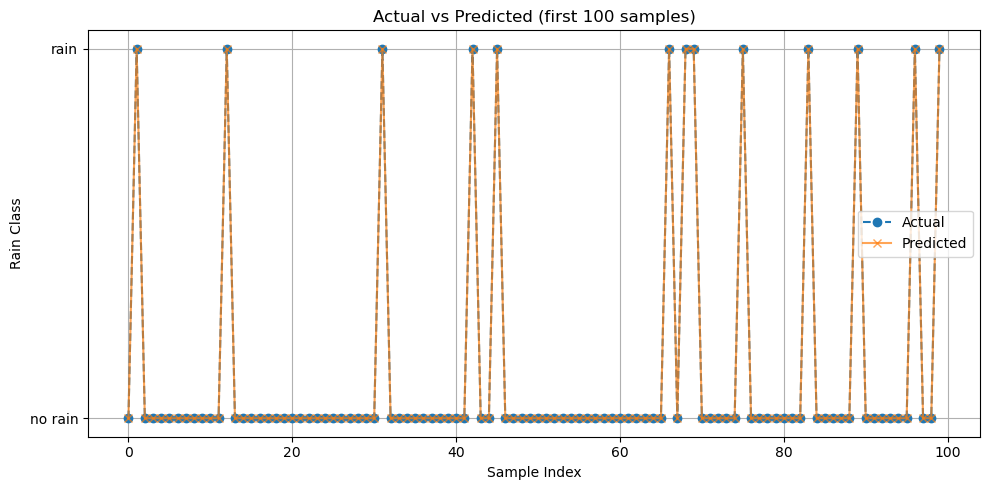

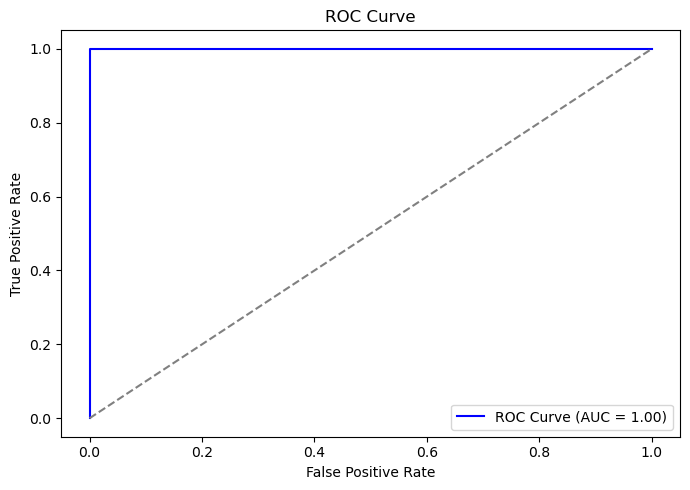

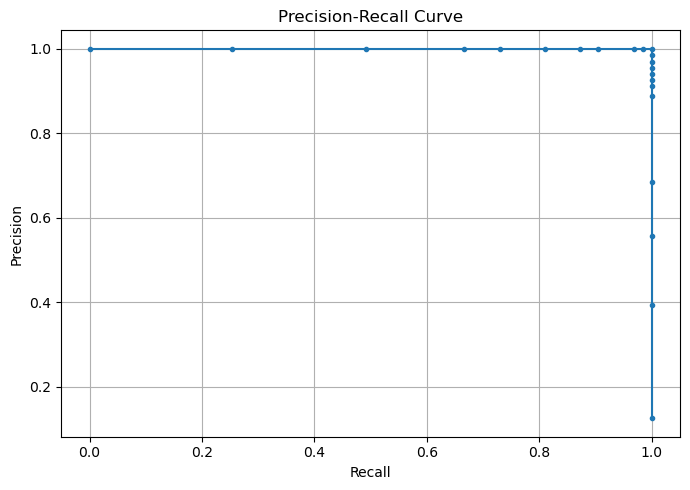

Predicted Weather Outcome: no rain ,for given weather input


C:\Users\oosun\AppData\Local\Temp\ipykernel_4004\3393781384.py:78: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_input = df_input.apply(pd.to_numeric, errors='ignore')


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve

#Step 1: Import CSVs
df_train = pd.read_csv('../Data/train_data.csv', delimiter=",")
df_test = pd.read_csv('../Data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns=["City", "DateTime", "Rain"])
y_train = df_train['Rain']

X_test = df_test.drop(columns=["City", "DateTime", "Rain"])
y_test = df_test['Rain']

# Step 3: Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 14, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=47),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Step 4: Picking best model from tuning
best_rf = grid_search.best_estimator_

#Step 5: Save the model as pkl file in artifacts
with open("../Artifacts/randomforest_model.pkl", "wb") as file:
    pickle.dump(best_rf, file)

#Step 6: Predictions
predictions = best_rf.predict(X_test)

# Step 7: Evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions, target_names=["No Rain", "Rain"], zero_division=0))

#Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Prediction function 
def predict_weather(input_string):
    columns = ["Temperature", "Humidity", "Wind_Speed", "Cloud_Cover", "Pressure"]

    # Convert input string into a list
    input_data = input_string.split(",")

    # Automatically remove the first value (City) and second value (DateTime)
    input_data = input_data[2:]

    # Convert to DataFrame
    df_input = pd.DataFrame([input_data], columns=columns)

    # Convert numerical values from strings to floats
    df_input = df_input.apply(pd.to_numeric, errors='ignore') 

    # Predict using the loaded model
    prediction = best_rf.predict(df_input)

    return prediction[0]

#Step 8: Save predictions to CSV
comparison_df = X_test.copy()
comparison_df["Actual Rain"] = y_test.values
comparison_df["Predicted Rain"] = predictions
comparison_df.to_csv("../Data/randomforest_prediction.csv", index=False)

#Feture Importance
importances = best_rf.feature_importances_
features = X_train.columns
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()

#Match Count Bar Plot
comparison_df["Match"] = comparison_df["Actual Rain"] == comparison_df["Predicted Rain"]
plt.figure(figsize=(8, 5))
sns.countplot(data=comparison_df, x="Actual Rain", hue="Match", palette={True: "green", False: "red"})
plt.title("Correct vs Incorrect Predictions by Actual Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Predicted vs Actual Scatter (first 100 samples)
plt.figure(figsize=(10, 5))
plt.plot(comparison_df["Actual Rain"].values[:100], label="Actual", marker='o', linestyle='--')
plt.plot(comparison_df["Predicted Rain"].values[:100], label="Predicted", marker='x', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted (first 100 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Rain Class")
plt.grid(True)
plt.tight_layout()
plt.show()

#ROC Curve
if hasattr(best_rf, "predict_proba"):
    probs = best_rf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label='rain')
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

#Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, probs[:, 1], pos_label='rain')
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Example testing input from the csv file
weather_input = "Chicago,2023-12-15 01:26,27.31386567157817,94.69920342298845,13.537423774917874,56.54416888696837,1042.2283814225484"

#Print predicted grade
print(f"Predicted Weather Outcome: {predict_weather(weather_input)} ,for given weather input")